In [28]:
import os
import time
import json
import datetime as dt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import pwlf
from sklearn.utils import resample

In [29]:
# Selecting the game
game_name = 'goiwbf'

In [30]:
# Getting the game ID
base_url = 'https://www.speedrun.com/api/v1'

response = requests.get(f'{base_url}/games?name={game_name}')
data = response.json()

In [31]:
# Define the status, platform, order, direction, and max results
status = 'verified'
platform = '8gej2n93'  # Platform == PC
orderby = 'date'
direction = 'asc'
max_results = 200  # Maximum results per page

In [32]:
def get_game_id(game_name):
    response = requests.get(f'{base_url}/games?name={game_name}')
    data = response.json()
    if response.status_code == 200:
        return data['data'][0]['id']
    else:
        return None

get_game_id(game_name)

'pd0wx9w1'

In [33]:
# Define a function to get the categories for a game
def get_categories(game_id):
    response = requests.get(f'{base_url}/games/{game_id}/categories')
    if response.status_code == 200:
        data = response.json()
        categories = {}
        for category in data['data']:
            categories[category['id']] = category['name']
        return categories
    else:
        print(f'Request failed with status code {response.status_code}.')
        return None

In [34]:
# Define a function to get the runs for a category
def get_runs_for_category(game_id, category_id, category_name):
    extracted_data = []
    page = 0
    while True:
        offset = page * max_results
        response = requests.get(f'{base_url}/runs?game={game_id}&category={category_id}&status={status}&platform={platform}&orderby={orderby}&direction={direction}&max={max_results}&offset={offset}')
        if response.status_code == 200:
            data = response.json()
            if not data['data']:
                break
            for run in data['data']:
                date = run['date']
                submitted = run['submitted']
                verified = run['status']['status']
                primary_t = run['times']['primary_t']
                realtime_t = run['times']['realtime_t']
                extracted_data.append([date, submitted, verified, primary_t, realtime_t, category_name])
            print(f'Page {page + 1} processed for category {category_name}.')
        else:
            print(f'Request failed with status code {response.status_code}. Stopping data collection.')
            print(response.text)
            break
        time.sleep(.6)
        page += 1
    return extracted_data

In [35]:
# Get the game ID
game_id = get_game_id(game_name)

# Get the categories for the game
categories = get_categories(game_id)

# Initialize an empty list to store all the data
all_data = []

# Get the runs for each category
for category_id, category_name in categories.items():
    all_data.extend(get_runs_for_category(game_id, category_id, category_name))

# Convert the list to a DataFrame
df = pd.DataFrame(all_data, columns=['Date', 'Submitted', 'Verified', 'Primary_t', 'Realtime_t', 'Category'])

# Save the DataFrame to a CSV file
df.to_csv('speedrun_data.csv', index=False)

Page 1 processed for category Glitchless.
Page 2 processed for category Glitchless.
Page 3 processed for category Glitchless.
Page 4 processed for category Glitchless.
Page 5 processed for category Glitchless.
Page 6 processed for category Glitchless.
Page 7 processed for category Glitchless.
Page 8 processed for category Glitchless.
Page 9 processed for category Glitchless.
Page 10 processed for category Glitchless.
Page 11 processed for category Glitchless.
Page 12 processed for category Glitchless.
Page 13 processed for category Glitchless.
Page 14 processed for category Glitchless.
Page 15 processed for category Glitchless.
Page 16 processed for category Glitchless.
Page 17 processed for category Glitchless.
Page 18 processed for category Glitchless.
Page 19 processed for category Glitchless.
Page 20 processed for category Glitchless.
Page 21 processed for category Glitchless.
Page 22 processed for category Glitchless.
Page 23 processed for category Glitchless.
Page 24 processed fo

In [36]:
# Load the data from the CSV file into a new df
csv_df = pd.read_csv('speedrun_data.csv')
csv_df

,Date,Submitted,Verified,Primary_t,Realtime_t,Category
0,2017-10-08,2017-11-18T19:23:22Z,verified,527.647,527.647,Glitchless
1,2017-10-10,2017-11-18T19:26:47Z,verified,411.306,411.306,Glitchless
2,2017-10-12,2017-11-18T19:28:17Z,verified,352.972,352.972,Glitchless
3,2017-10-13,2017-10-24T22:11:52Z,verified,527.896,527.896,Glitchless
4,2017-10-14,2017-11-18T19:30:25Z,verified,331.720,331.720,Glitchless
...,...,...,...,...,...,...
11307,2024-02-25,2024-02-25T15:00:35Z,verified,2.993,2.993,Glitchless
11308,2024-02-25,2024-02-25T15:01:47Z,verified,6.950,6.950,Glitchless
11309,2024-02-25,2024-02-25T22:32:05Z,verified,9.329,9.329,Glitchless
11310,2024-02-28,2024-02-28T06:19:46Z,verified,8.938,8.938,Glitchless


In [37]:
# Filter out rows where 'Date' or 'Submitted' is None
csv_df = csv_df[csv_df['Date'].notnull() & csv_df['Submitted'].notnull()]
print(csv_df.count())
# Filter out Realtime that is 0
csv_df = csv_df[csv_df['Primary_t'] > 0.1]
csv_df.count()

Date          11312
Submitted     11312
Verified      11312
Primary_t     11312
Realtime_t    11312
Category      11312
dtype: int64


Date          11312
Submitted     11312
Verified      11312
Primary_t     11312
Realtime_t    11312
Category      11312
dtype: int64

In [38]:
csv_df['Category'].value_counts()

Category
Glitchless    10761
Snake           551
Name: count, dtype: int64

In [39]:
# Get the category with the most runs
top_category = csv_df['Category'].value_counts().idxmax()

# Filter the DataFrame to only include runs from the top category
csv_df = csv_df[csv_df['Category'] == top_category]
top_category

'Glitchless'

### Preparing data to do linear fit

In [47]:
# Getting the running top score
csv_df['Top_Score'] = csv_df['Primary_t'].cummin()

# Converting 'Date' is in datetime format
csv_df['Date'] = pd.to_datetime(csv_df['Date'])

# Sort by date
csv_df = csv_df.sort_values('Date')

print(csv_df.tail(50))

# Define x (date) and y (top score)
x = csv_df['Date'].map(dt.datetime.toordinal).values
y = csv_df['Top_Score'].values

# Initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# Fit the data for two line segments
res = my_pwlf.fit(2)

# Predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

# Convert the ordinal dates back to datetime for plotting
x_dates = [dt.datetime.fromordinal(int(i)) for i in xHat]

            Date             Submitted  Verified  Primary_t  Realtime_t  \
11262 2023-11-26  2023-11-26T13:12:29Z  verified     14.589      14.589   
11263 2023-12-01  2023-12-01T04:28:20Z  verified     12.460      12.460   
11264 2023-12-01  2023-12-01T13:08:34Z  verified      8.149       8.149   
11265 2023-12-02  2023-12-02T05:37:49Z  verified      9.225       9.225   
11266 2023-12-08  2023-12-08T06:25:36Z  verified      5.091       5.091   
11267 2023-12-10  2023-12-10T01:26:48Z  verified     10.441      10.441   
11268 2023-12-11  2023-12-11T05:06:17Z  verified      3.065       3.065   
11269 2023-12-13  2023-12-13T01:34:50Z  verified      7.626       7.626   
11270 2023-12-13  2023-12-13T01:36:25Z  verified      9.753       9.753   
11271 2023-12-17  2024-01-07T08:57:03Z  verified      2.916       2.916   
11272 2023-12-19  2023-12-19T11:38:09Z  verified      4.984       4.984   
11273 2023-12-19  2023-12-19T11:39:20Z  verified      9.660       9.660   
11274 2023-12-22  2023-12

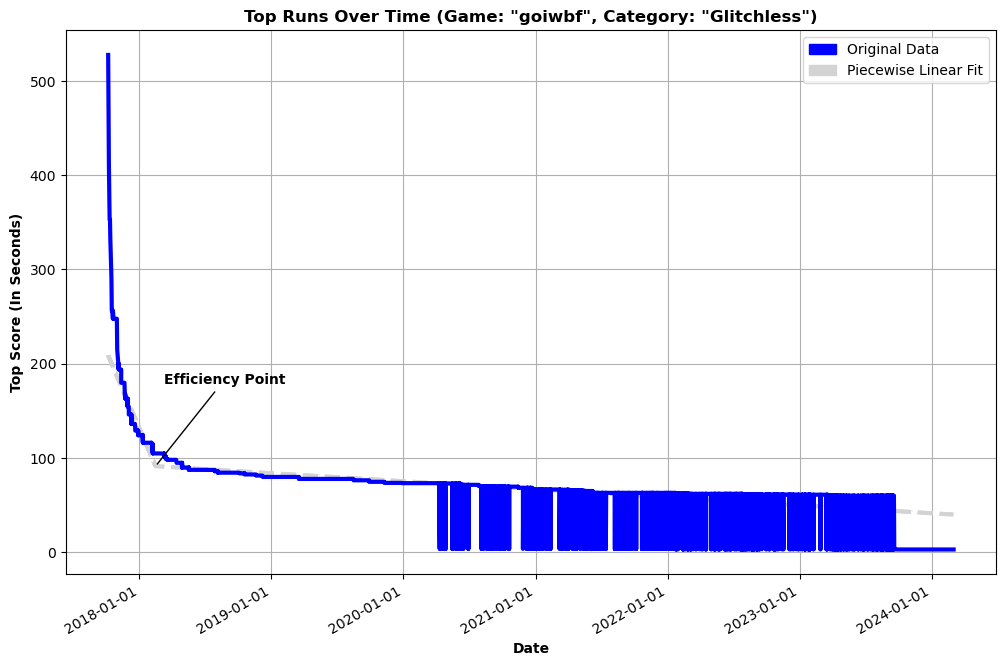

In [41]:
# Create a new figure and axes with a larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the piecewise linear fit
ax.plot(x_dates, yHat, linestyle='--', linewidth=3, color='lightgrey', label='Piecewise Linear Fit')

# Plot the original data
ax.plot(csv_df['Date'], csv_df['Top_Score'], linestyle='solid', linewidth=3, color='blue', label='Original Data')

# Get the breakpoints that were calculated during the fit
breakpoints = my_pwlf.fit_breaks

# The elbow is the second breakpoint (the first one is the start of the data)
elbow_x = breakpoints[1]
elbow_y = my_pwlf.predict(elbow_x)

# Convert the ordinal date back to a datetime
elbow_date = dt.datetime.fromordinal(int(elbow_x))

# Define the end point of the line (getting the label closer to the middle of the graph)
end_x = elbow_date + (max(csv_df['Date']) - elbow_date) / 100
end_y = elbow_y + (max(csv_df['Top_Score']) - elbow_y) / 5

# Add the annotation for the elbow with a line going to the middle of the graph
ax.annotate('Efficiency Point', fontweight='bold',
            xy=(elbow_date, elbow_y),
            xytext=(end_x, end_y),
            arrowprops=dict(arrowstyle='-', color='black'))

# Set the title and labels
ax.set_title(f'Top Runs Over Time (Game: "{game_name}", Category: "{top_category}")', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Top Score (In Seconds)', fontweight='bold')

# Format date
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Rotate date labels automatically
fig.autofmt_xdate()

# Create custom legend handles
handle1 = mpatches.Patch(color='blue', label='Original Data')
handle2 = mpatches.Patch(color='lightgrey', label='Piecewise Linear Fit')

# Add the custom legend
ax.legend(handles=[handle1, handle2], loc='upper right')

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()

In [42]:
# Get the index of the elbow in the original data
elbow_index = np.abs(x - elbow_x).argmin()

# Calculate the number of runs to the efficiency point
runs_to_efficiency = elbow_index + 1  # add 1 because indexing starts at 0

# Calculate the percentage of runs complete at efficiency
pct_runs_complete_at_efficiency = (runs_to_efficiency / len(x)) * 100

# Calculate the number of days to the efficiency point
days_to_efficiency = (elbow_date - min(csv_df['Date'])).days

# Calculate the total number of days in the data
total_days = (max(csv_df['Date']) - min(csv_df['Date'])).days

# Calculate the percentage of days to efficiency out of total days
pct_days_to_efficiency = (days_to_efficiency / total_days) * 100

# Convert elbow_y to a float
elbow_y_float = float(elbow_y[0])

# Get the last row (the latest top score)
latest_top_score = csv_df.iloc[-1]['Top_Score']

# Print the information
print(f"Number of runs to efficiency point: {runs_to_efficiency}")
print(f"Total runs: {len(x)}")
print(f"Date of efficiency: {elbow_date.strftime('%Y-%m-%d')}")
print(f"Score at efficiency: {elbow_y_float:.2f}")
print(f"Latest Top Score: {latest_top_score:.2f}")
print(f"Percentage of runs complete at efficiency: {pct_runs_complete_at_efficiency:.2f}%")

# Print the information
print("")
print(f"Number of days to the efficiency point: {days_to_efficiency}")
print(f"Total number of days: {total_days}")
print(f"Percentage of days to efficiency: {pct_days_to_efficiency:.2f}%")

Number of runs to efficiency point: 1136
Total runs: 10761
Date of efficiency: 2018-02-16
Score at efficiency: 91.26
Latest Top Score: 2.83
Percentage of runs complete at efficiency: 10.56%

Number of days to the efficiency point: 131
Total number of days: 2336
Percentage of days to efficiency: 5.61%


In [43]:
# Initialize a list to store the Jackknife efficiency points
jackknife_efficiency_points = []

# Perform Jackknife resampling
for i in range(len(x)):
    # Create a resampled dataset by leaving out one observation
    resampled_x = np.delete(x, i)
    resampled_y = np.delete(y, i)
    
    # Calculate the efficiency point for the resampled dataset
    my_pwlf = pwlf.PiecewiseLinFit(resampled_x, resampled_y)
    res = my_pwlf.fit(2)
    elbow_x = res[1]  # the change point in the piecewise linear fit
    
    # Append the resampled efficiency point to the list
    jackknife_efficiency_points.append(elbow_x)

    # Print progress
    if (i+1) % 100 == 0:
        print(f"Completed {i+1} Jackknife samples out of {len(x)} Total Runs")

# Convert the list to a numpy array
jackknife_efficiency_points = np.array(jackknife_efficiency_points)

# Calculate the 99% confidence interval
ci_lower = np.percentile(jackknife_efficiency_points, 0.5)
ci_upper = np.percentile(jackknife_efficiency_points, 99.5)

# Convert the confidence interval bounds from ordinal date to regular date
ci_lower_date = dt.datetime.fromordinal(int(ci_lower))
ci_upper_date = dt.datetime.fromordinal(int(ci_upper))

print(f"99% confidence interval for the efficiency point:")
print(f"Early Date: {ci_lower_date.strftime('%Y-%m-%d')}")
print(f"Late Date: {ci_upper_date.strftime('%Y-%m-%d')}")
print(f"Estimated Date of efficiency: {elbow_date.strftime('%Y-%m-%d')}")

Completed 100 Jackknife samples out of 10761 Total Runs
Completed 200 Jackknife samples out of 10761 Total Runs
Completed 300 Jackknife samples out of 10761 Total Runs
Completed 400 Jackknife samples out of 10761 Total Runs
Completed 500 Jackknife samples out of 10761 Total Runs
Completed 600 Jackknife samples out of 10761 Total Runs
Completed 700 Jackknife samples out of 10761 Total Runs
Completed 800 Jackknife samples out of 10761 Total Runs
Completed 900 Jackknife samples out of 10761 Total Runs
Completed 1000 Jackknife samples out of 10761 Total Runs
Completed 1100 Jackknife samples out of 10761 Total Runs
Completed 1200 Jackknife samples out of 10761 Total Runs
Completed 1300 Jackknife samples out of 10761 Total Runs
Completed 1400 Jackknife samples out of 10761 Total Runs


KeyboardInterrupt: 

In [ ]:
# Convert the dates to numerical format for plotting
jackknife_efficiency_points_num = mdates.date2num([dt.datetime.fromordinal(int(x)) for x in jackknife_efficiency_points])
ci_lower_date_num = mdates.date2num(ci_lower_date)
ci_upper_date_num = mdates.date2num(ci_upper_date)

# Create a new figure and axes with a larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Create a histogram of the jackknife efficiency points
plt.hist(jackknife_efficiency_points_num, bins=30, alpha=0.5, color='steelblue', edgecolor='black')

# Add a vertical line for the lower and upper bounds of the 99% confidence interval
plt.axvline(ci_lower_date_num, color='red', linestyle='dashed', linewidth=2, label='Confidence Interval')
plt.axvline(ci_upper_date_num, color='red', linestyle='dashed', linewidth=2)
plt.axvline(elbow_date, color='blue', linestyle='dashed', linewidth=2, label='Efficiency Point')

# Add a title and labels
plt.title('Jackknife Efficiency Points')
plt.xlabel('Efficiency Point')
plt.ylabel('Frequency')

# Change x-axis labels back to dates
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

# Add a legend
plt.legend()

# Rotate date labels to prevent overlap
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Convert the efficiency points from ordinal date to numerical format for plotting
bootstrap_efficiency_dates_num = mdates.date2num([dt.datetime.fromordinal(int(x)) for x in jackknife_efficiency_points])

# Create a box plot of the bootstrap efficiency dates
plt.figure(figsize=(12, 8))
plt.boxplot(bootstrap_efficiency_dates_num, vert=False)

# Add a title and labels
plt.title('Bootstrap Efficiency Dates')
plt.xlabel('Date')

# Change x-axis labels back to dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add a vertical line for the efficiency date
efficiency_date_num = mdates.date2num(elbow_date)
plt.axvline(x=efficiency_date_num, color='r', linestyle='--')

# Rotate date labels to prevent overlap
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
'''
# Create a DataFrame with the relevant data
efficiency_data = pd.DataFrame({
    'Game': [game_name],
    'Top Category': [top_category],
    'Number of runs to efficiency point': [runs_to_efficiency],
    'Total runs': [len(x)],
    'Date of efficiency': [elbow_date.strftime('%Y-%m-%d')],
    'Score at efficiency': [elbow_y_float],
    'Latest Top Score': [latest_top_score],
    'Percentage of runs complete at efficiency': [pct_runs_complete_at_efficiency],
    'Number of days to the efficiency point': [days_to_efficiency],
    'Total number of days': [total_days],
    'Percentage of days to efficiency': [pct_days_to_efficiency]
})
efficiency_data
'''

In [ ]:
'''
# Check if the file exists, if not, create one with a header. Otherwise append.
if not os.path.isfile('efficiency_data.csv'):
    efficiency_data.to_csv('efficiency_data.csv', mode='a', header=True)
else:
    efficiency_data.to_csv('efficiency_data.csv', mode='a', header=False)
'''